In [1]:
# Import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from PIL import Image
import random
from tqdm import tqdm

In [2]:
# Load in dataset
train_dir = "/kaggle/input/70-dog-breedsimage-data-set"
data_df = pd.read_csv(f"{train_dir}/dogs.csv")
data_df.head()

,filepaths,labels,data set
0,train/Afghan/001.jpg,Afghan,train
1,train/Afghan/002.jpg,Afghan,train
2,train/Afghan/003.jpg,Afghan,train
3,train/Afghan/004.jpg,Afghan,train
4,train/Afghan/005.jpg,Afghan,train


In [3]:
# Split into training, validation, and test data
train_df = data_df[data_df.iloc[:, 2] == "train"].copy()
valid_df = data_df[data_df.iloc[:, 2] == "valid"].copy()
test_df = data_df[data_df.iloc[:, 2] == "test"].copy()
train_df.head()

,filepaths,labels,data set
0,train/Afghan/001.jpg,Afghan,train
1,train/Afghan/002.jpg,Afghan,train
2,train/Afghan/003.jpg,Afghan,train
3,train/Afghan/004.jpg,Afghan,train
4,train/Afghan/005.jpg,Afghan,train


In [4]:
# Encode labels
encoded_train_labels, _ = pd.factorize(train_df["labels"])
encoded_valid_labels, _ = pd.factorize(valid_df["labels"])
encoded_test_labels, _ = pd.factorize(test_df["labels"])
train_df["encoded_labels"] = encoded_train_labels
valid_df["encoded_labels"] = encoded_valid_labels
test_df["encoded_labels"] = encoded_test_labels

print(set(encoded_train_labels))
data_df.head()

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69}


,filepaths,labels,data set
0,train/Afghan/001.jpg,Afghan,train
1,train/Afghan/002.jpg,Afghan,train
2,train/Afghan/003.jpg,Afghan,train
3,train/Afghan/004.jpg,Afghan,train
4,train/Afghan/005.jpg,Afghan,train


In [5]:
# Drop unnecessary columns
columns_to_drop = ["labels", "data set"]
train_df = train_df.drop(columns = columns_to_drop)
valid_df = valid_df.drop(columns = columns_to_drop)
test_df = test_df.drop(columns = columns_to_drop)
print(train_df.head())
print(valid_df.head())
print(test_df.head())

              filepaths  encoded_labels
0  train/Afghan/001.jpg               0
1  train/Afghan/002.jpg               0
2  train/Afghan/003.jpg               0
3  train/Afghan/004.jpg               0
4  train/Afghan/005.jpg               0
                filepaths  encoded_labels
8646  valid/Afghan/01.jpg               0
8647  valid/Afghan/02.jpg               0
8648  valid/Afghan/03.jpg               0
8649  valid/Afghan/04.jpg               0
8650  valid/Afghan/05.jpg               0
               filepaths  encoded_labels
7946  test/Afghan/01.jpg               0
7947  test/Afghan/02.jpg               0
7948  test/Afghan/03.jpg               0
7949  test/Afghan/04.jpg               0
7950  test/Afghan/05.jpg               0


In [6]:
# Make labels first column
new_order = ["encoded_labels", "filepaths"]
train_df = train_df[new_order]
valid_df = valid_df[new_order]
test_df = test_df[new_order]
print(train_df.head())
print(valid_df.head())
print(test_df.head())

   encoded_labels             filepaths
0               0  train/Afghan/001.jpg
1               0  train/Afghan/002.jpg
2               0  train/Afghan/003.jpg
3               0  train/Afghan/004.jpg
4               0  train/Afghan/005.jpg
      encoded_labels            filepaths
8646               0  valid/Afghan/01.jpg
8647               0  valid/Afghan/02.jpg
8648               0  valid/Afghan/03.jpg
8649               0  valid/Afghan/04.jpg
8650               0  valid/Afghan/05.jpg
      encoded_labels           filepaths
7946               0  test/Afghan/01.jpg
7947               0  test/Afghan/02.jpg
7948               0  test/Afghan/03.jpg
7949               0  test/Afghan/04.jpg
7950               0  test/Afghan/05.jpg


In [7]:
# TRAINING
# Convert filepaths to numpy arrays
train_df["images"] = train_dir + "/" + train_df["filepaths"]
train_df = train_df.drop(columns=["filepaths"])
train_df["images"] = train_df["images"].apply(lambda path: np.array(Image.open(path).convert("L")))
train_df.head()

,encoded_labels,images
0,0,"[[129, 126, 107, 111, 121, 120, 115, 114, 119,..."
1,0,"[[118, 90, 56, 40, 26, 7, 17, 27, 30, 23, 13, ..."
2,0,"[[128, 124, 112, 114, 113, 113, 121, 114, 103,..."
3,0,"[[124, 121, 114, 105, 98, 91, 83, 75, 68, 67, ..."
4,0,"[[184, 187, 189, 187, 183, 181, 183, 187, 189,..."


In [8]:
# Flatten images
pixels = np.stack(train_df['images'].values).reshape(len(train_df), -1)

In [9]:
# Create columns for individual pixels of images
pixels_df = pd.DataFrame(pixels, columns=[f"pixel_{i}" for i in range(pixels.shape[1])])
train_df = pd.concat([train_df['encoded_labels'], pixels_df], axis=1)
train_df.head()

,encoded_labels,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_50166,pixel_50167,pixel_50168,pixel_50169,pixel_50170,pixel_50171,pixel_50172,pixel_50173,pixel_50174,pixel_50175
0,0,129,126,107,111,121,120,115,114,119,...,108,95,89,86,82,79,75,71,69,70
1,0,118,90,56,40,26,7,17,27,30,...,249,249,248,248,247,246,246,246,246,246
2,0,128,124,112,114,113,113,121,114,103,...,139,137,138,140,145,152,156,155,151,148
3,0,124,121,114,105,98,91,83,75,68,...,161,161,161,161,161,162,164,165,166,167
4,0,184,187,189,187,183,181,183,187,189,...,83,79,80,68,39,34,89,163,181,112


In [10]:
# Create numpy array representing all training images
train_data = train_df.to_numpy()
np.random.shuffle(train_data)
print(train_data)

[[ 38 240 240 ... 240 240 240]
 [ 43 206 206 ...  91 123 144]
 [ 58  30  30 ...  27  28  29]
 ...
 [ 42  49  49 ... 113 143 133]
 [ 18  89  99 ...  84  76  81]
 [ 61  67  66 ...  82  80  78]]


In [11]:
# Separate image data from labels
X_train = train_data[:, 1:]
Y_train = train_data[:, 0]
print(X_train)
print(Y_train)

[[240 240 240 ... 240 240 240]
 [206 206 206 ...  91 123 144]
 [ 30  30  30 ...  27  28  29]
 ...
 [ 49  49  43 ... 113 143 133]
 [ 89  99 100 ...  84  76  81]
 [ 67  66  73 ...  82  80  78]]
[38 43 58 ... 42 18 61]


In [12]:
# Normalize data
X_train = X_train / 255
print(X_train)

[[0.94117647 0.94117647 0.94117647 ... 0.94117647 0.94117647 0.94117647]
 [0.80784314 0.80784314 0.80784314 ... 0.35686275 0.48235294 0.56470588]
 [0.11764706 0.11764706 0.11764706 ... 0.10588235 0.10980392 0.11372549]
 ...
 [0.19215686 0.19215686 0.16862745 ... 0.44313725 0.56078431 0.52156863]
 [0.34901961 0.38823529 0.39215686 ... 0.32941176 0.29803922 0.31764706]
 [0.2627451  0.25882353 0.28627451 ... 0.32156863 0.31372549 0.30588235]]


In [13]:
n, m = X_train.shape
output_size = len(set(encoded_train_labels))
hidden_size = 200
print(m)
print(hidden_size)
print(output_size)
X_train.shape

50176
200
70


(7946, 50176)

In [14]:
# Define activation function for hidden layer
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(Z):
    ds = sigmoid(Z)
    return ds * (1 - ds)

# Define probability function for output layer
def softmax(Z):
    exps = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    prob = exps / np.sum(exps, axis=1, keepdims=True)
    return prob

In [15]:
#Initialize weights and biases
def init_params():
    W1 = np.random.randn(m, hidden_size) * np.sqrt(2 / m)
    b1 = np.zeros(hidden_size)
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
    b2 = np.zeros(output_size)
    return W1, b1, W2, b2

In [16]:
# Define forward propagation
def forward_prop(W1, b1, W2, b2, X):
    Z1 = np.dot(X, W1) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

In [17]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, output_size))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y

In [18]:
# Define backward propagation
def backward_prop(Z1, A1, Z2, A2, W2, X, Y):
    batch_size = len(X)
    one_hot_Y = one_hot(Y)
   
    dZ2 = A2 - one_hot_Y
    dW2 = np.dot(A1.T, dZ2) / batch_size
    db2 = np.sum(dZ2, axis=0) / batch_size
    dZ1 = np.dot(dZ2, W2.T) * sigmoid_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / batch_size
    db1 = np.sum(dZ1, axis=0) / batch_size 

    return dW1, db1, dW2, db2

In [19]:
def compute_accuracy(X_pred, Y):
    preds = np.argmax(X_pred, axis=1)
    accuracy = np.mean(preds == Y)
    return accuracy

def compute_cross_entropy_loss(X_pred, Y):
    M = len(Y)
    log_likelihood = -np.log(X_pred[range(M), Y])
    loss = np.sum(log_likelihood) / M
    return loss

In [20]:
def train(X, Y, learning_rate=0.01, batch_size=32, epochs=5):
    W1, b1, W2, b2 = init_params()
    loss_data = []
    for epoch in range(epochs):
        for batch_start in tqdm(range(0, len(X), batch_size)):
            X_batch = X[batch_start:(batch_start+batch_size), :]
            Y_batch = Y[batch_start:(batch_start+batch_size)]
            
            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_batch)
            loss = compute_cross_entropy_loss(A2, Y_batch)
            accuracy = compute_accuracy(A2, Y_batch)
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W2, X_batch, Y_batch)

            # Update weights and biases
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2
            b2 -= learning_rate * db2
            
            loss_data.append(loss)
            
            if (batch_start // batch_size) % 1 == 0:
                print(f"Batch {batch_start // batch_size}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
                plt.plot(loss_data)
                plt.show()
                
        print(f"Epoch {epoch} completed.")
                
    return W1, b1, W2, b2

  0%|          | 0/8 [00:00<?, ?it/s]

Batch 0: Loss = 4.4195, Accuracy = 0.0137


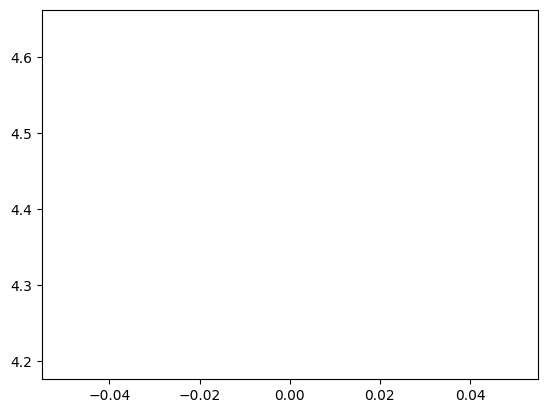

 12%|█▎        | 1/8 [00:01<00:12,  1.74s/it]

Batch 1: Loss = 4.3627, Accuracy = 0.0107


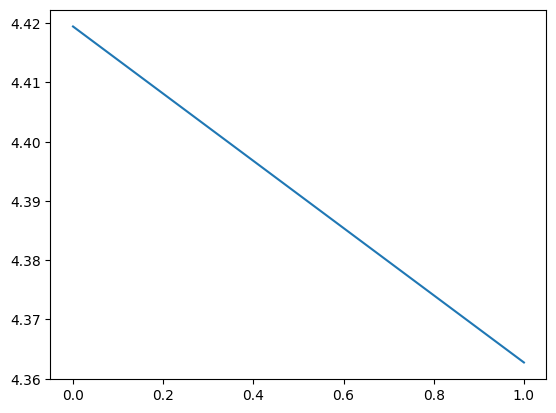

 25%|██▌       | 2/8 [00:03<00:10,  1.74s/it]

Batch 2: Loss = 4.3120, Accuracy = 0.0137


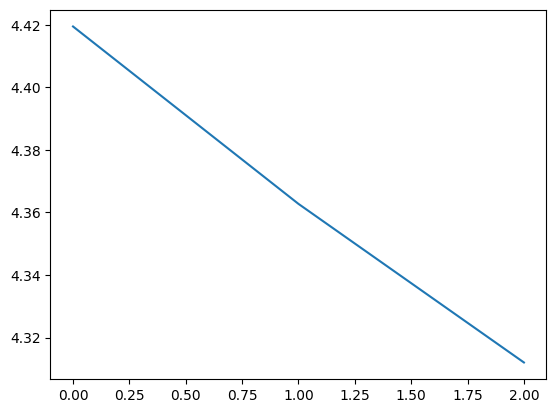

 38%|███▊      | 3/8 [00:05<00:08,  1.76s/it]

Batch 3: Loss = 4.2985, Accuracy = 0.0146


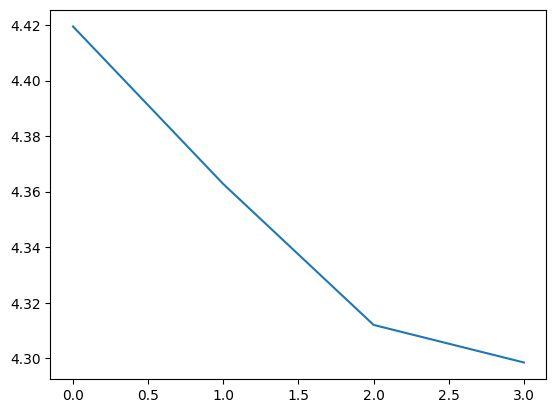

 50%|█████     | 4/8 [00:06<00:06,  1.74s/it]

Batch 4: Loss = 4.2912, Accuracy = 0.0186


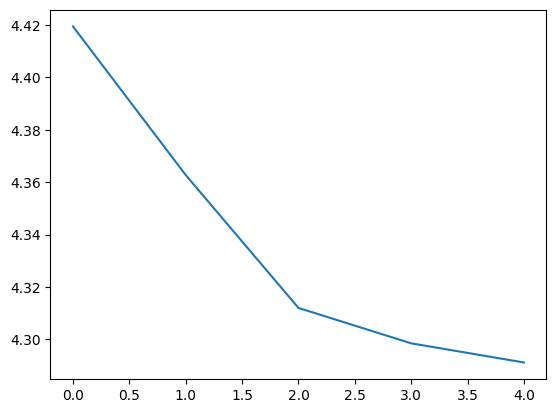

 62%|██████▎   | 5/8 [00:08<00:05,  1.73s/it]

Batch 5: Loss = 4.2665, Accuracy = 0.0186


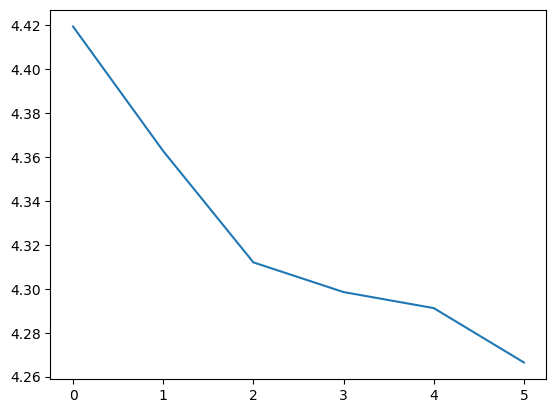

 75%|███████▌  | 6/8 [00:10<00:03,  1.74s/it]

Batch 6: Loss = 4.2706, Accuracy = 0.0156


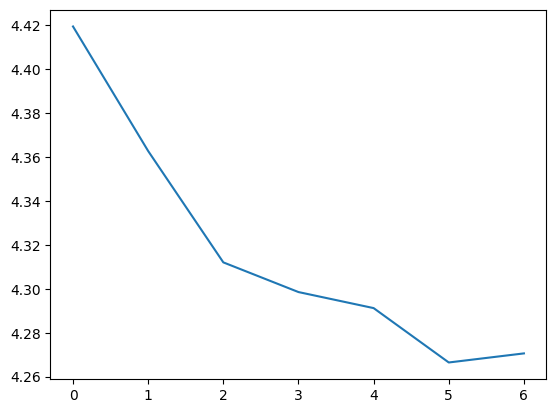

 88%|████████▊ | 7/8 [00:12<00:01,  1.76s/it]

Batch 7: Loss = 4.2670, Accuracy = 0.0193


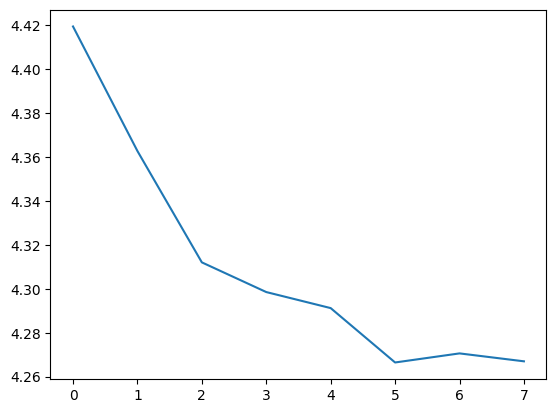

100%|██████████| 8/8 [00:13<00:00,  1.72s/it]


Epoch 0 completed.


  0%|          | 0/8 [00:00<?, ?it/s]

Batch 0: Loss = 4.2390, Accuracy = 0.0176


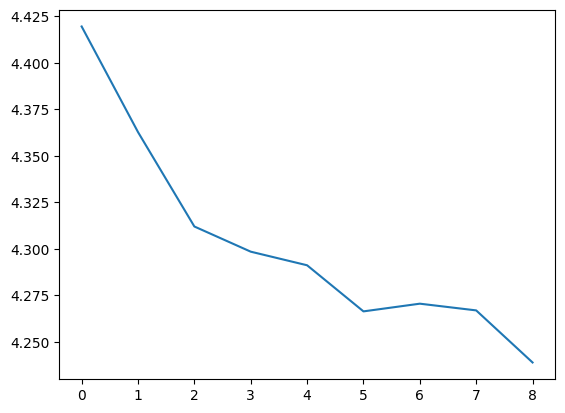

 12%|█▎        | 1/8 [00:01<00:11,  1.70s/it]

Batch 1: Loss = 4.2364, Accuracy = 0.0176


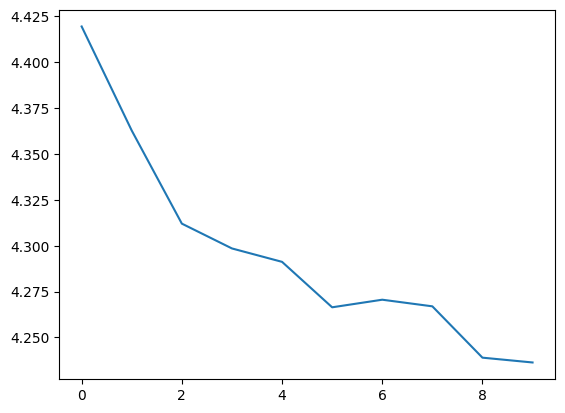

 25%|██▌       | 2/8 [00:03<00:10,  1.74s/it]

Batch 2: Loss = 4.2348, Accuracy = 0.0176


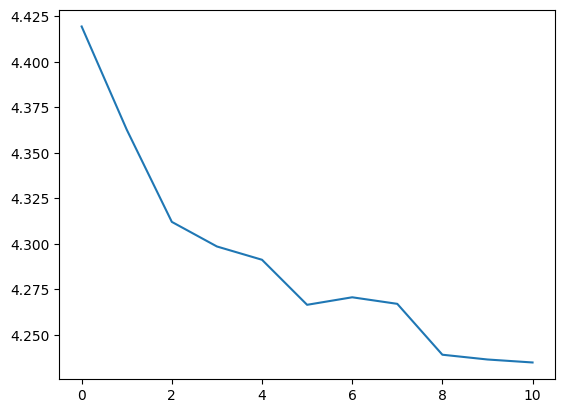

 38%|███▊      | 3/8 [00:05<00:08,  1.74s/it]

Batch 3: Loss = 4.2407, Accuracy = 0.0195


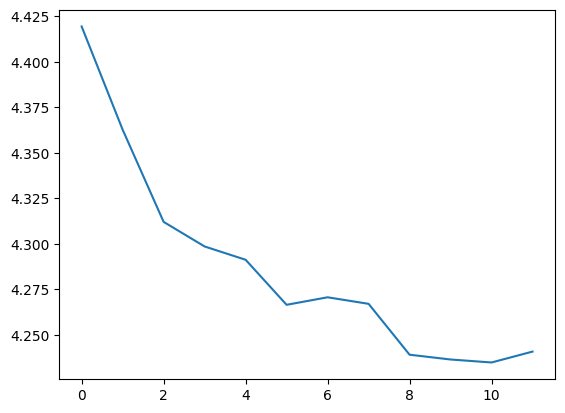

 50%|█████     | 4/8 [00:07<00:08,  2.03s/it]

Batch 4: Loss = 4.2324, Accuracy = 0.0215


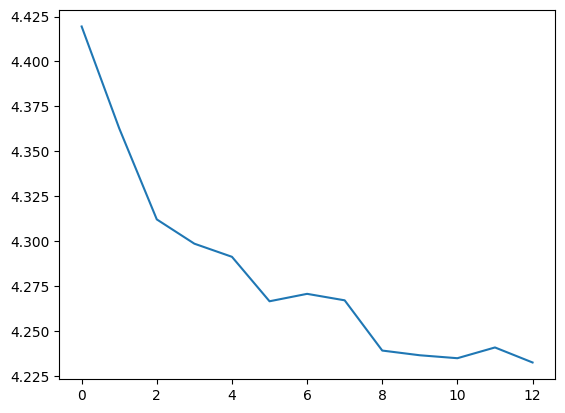

 62%|██████▎   | 5/8 [00:09<00:05,  1.91s/it]

Batch 5: Loss = 4.2205, Accuracy = 0.0352


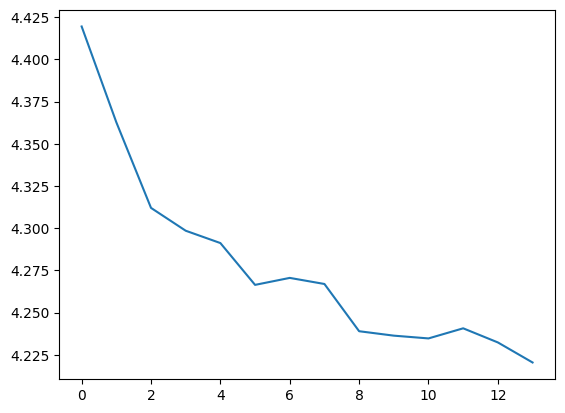

 75%|███████▌  | 6/8 [00:11<00:03,  1.89s/it]

Batch 6: Loss = 4.2290, Accuracy = 0.0225


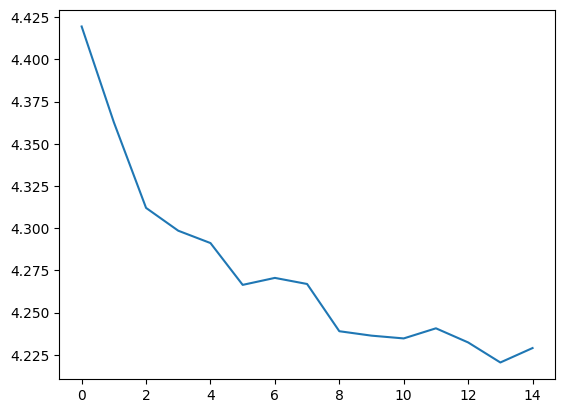

 88%|████████▊ | 7/8 [00:12<00:01,  1.84s/it]

Batch 7: Loss = 4.2274, Accuracy = 0.0347


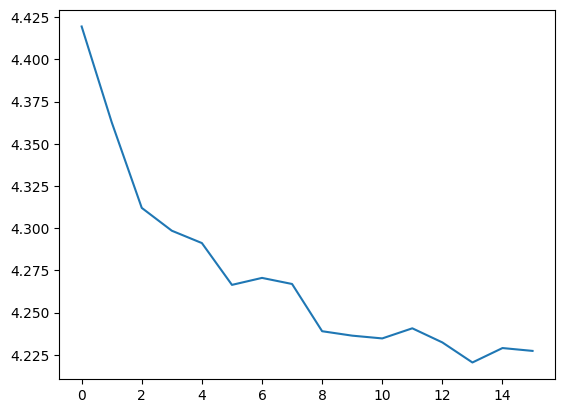

100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


Epoch 1 completed.


  0%|          | 0/8 [00:00<?, ?it/s]

Batch 0: Loss = 4.2094, Accuracy = 0.0312


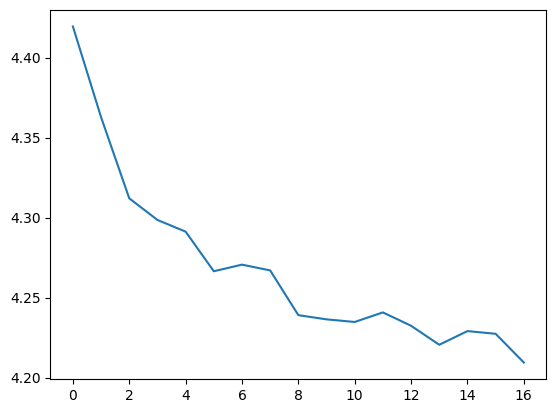

 12%|█▎        | 1/8 [00:01<00:11,  1.67s/it]

Batch 1: Loss = 4.2061, Accuracy = 0.0293


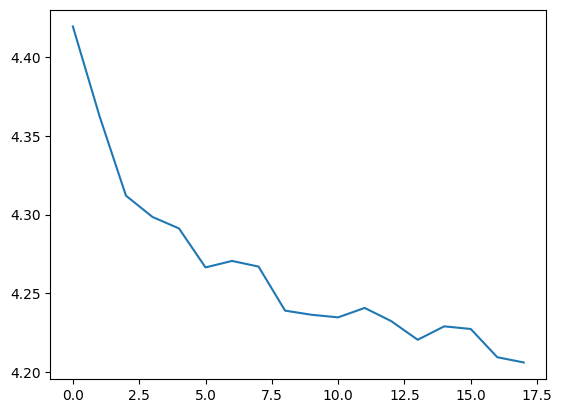

 25%|██▌       | 2/8 [00:03<00:09,  1.66s/it]

Batch 2: Loss = 4.2087, Accuracy = 0.0225


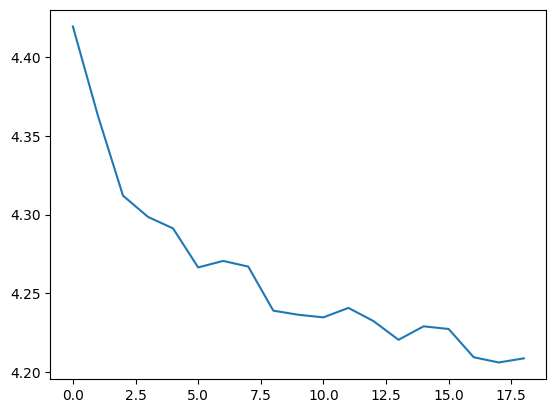

 38%|███▊      | 3/8 [00:04<00:08,  1.66s/it]

Batch 3: Loss = 4.2153, Accuracy = 0.0244


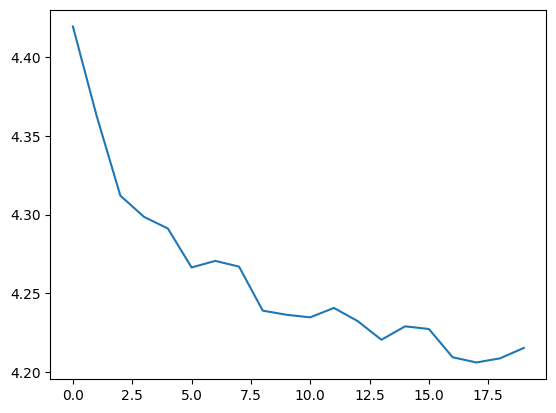

 50%|█████     | 4/8 [00:06<00:06,  1.70s/it]

Batch 4: Loss = 4.2061, Accuracy = 0.0312


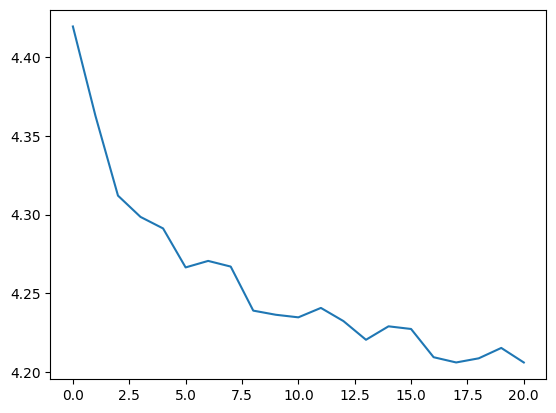

 62%|██████▎   | 5/8 [00:08<00:05,  1.70s/it]

Batch 5: Loss = 4.1980, Accuracy = 0.0361


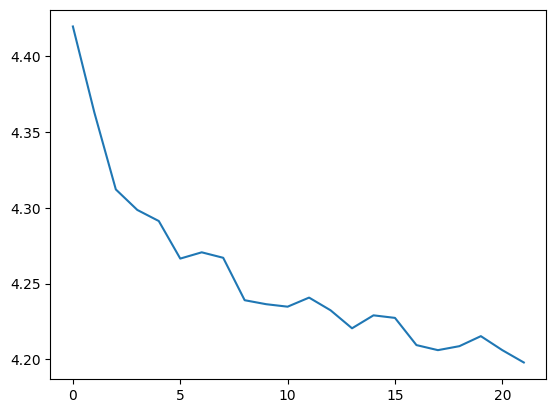

 75%|███████▌  | 6/8 [00:10<00:03,  1.70s/it]

Batch 6: Loss = 4.2075, Accuracy = 0.0273


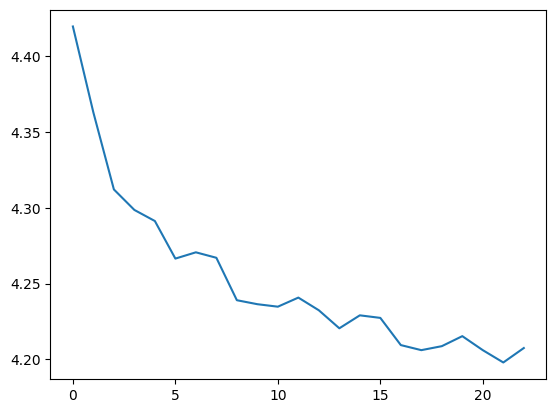

 88%|████████▊ | 7/8 [00:11<00:01,  1.75s/it]

Batch 7: Loss = 4.2054, Accuracy = 0.0398


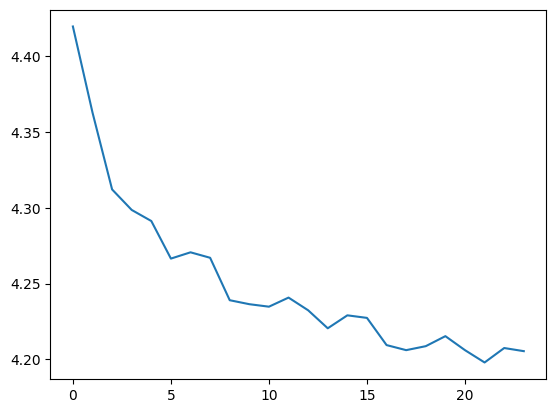

100%|██████████| 8/8 [00:13<00:00,  1.68s/it]


Epoch 2 completed.


  0%|          | 0/8 [00:00<?, ?it/s]

Batch 0: Loss = 4.1915, Accuracy = 0.0361


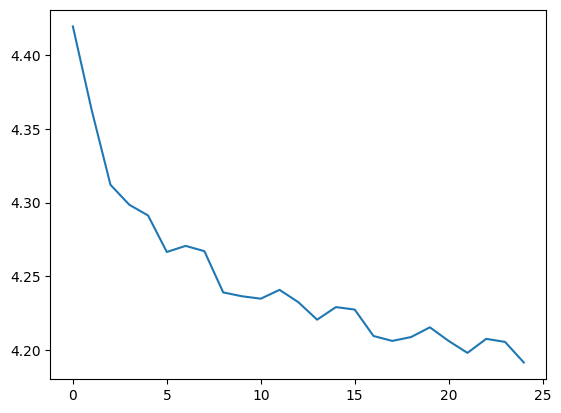

 12%|█▎        | 1/8 [00:01<00:11,  1.65s/it]

Batch 1: Loss = 4.1878, Accuracy = 0.0342


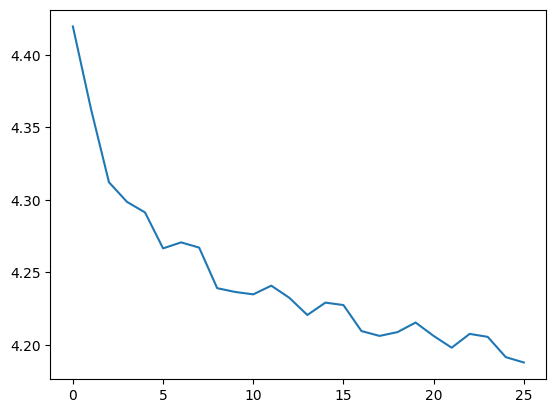

 25%|██▌       | 2/8 [00:03<00:10,  1.71s/it]

Batch 2: Loss = 4.1910, Accuracy = 0.0244


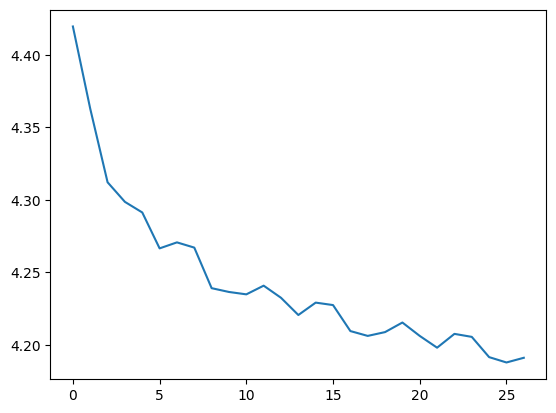

 38%|███▊      | 3/8 [00:05<00:08,  1.71s/it]

Batch 3: Loss = 4.1969, Accuracy = 0.0244


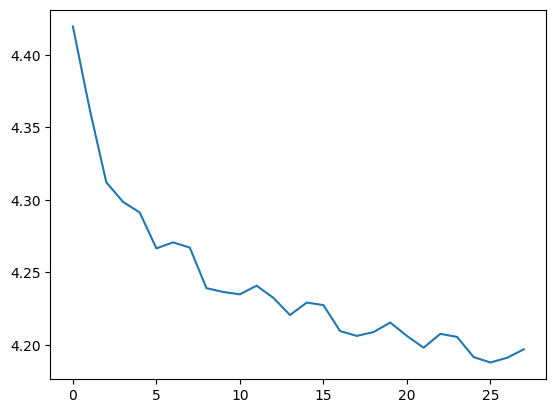

 50%|█████     | 4/8 [00:06<00:06,  1.71s/it]

Batch 4: Loss = 4.1870, Accuracy = 0.0283


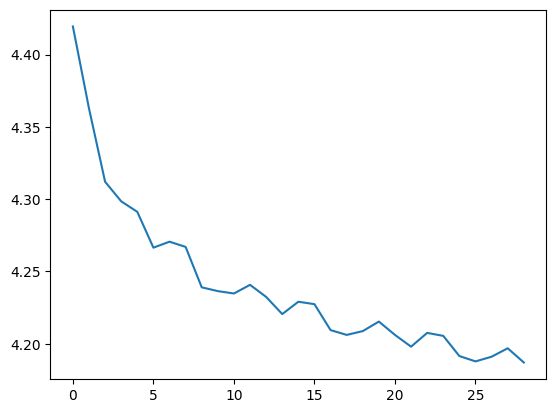

 62%|██████▎   | 5/8 [00:08<00:05,  1.71s/it]

Batch 5: Loss = 4.1813, Accuracy = 0.0410


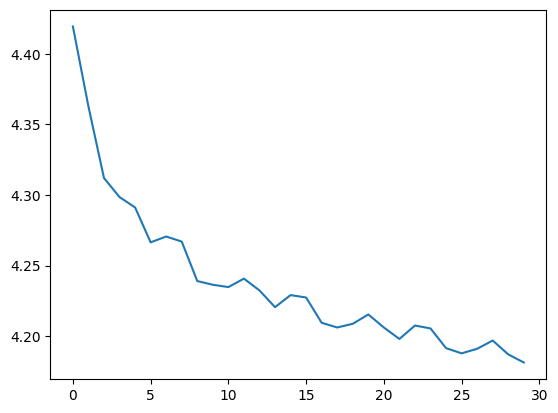

 75%|███████▌  | 6/8 [00:10<00:03,  1.80s/it]

Batch 6: Loss = 4.1914, Accuracy = 0.0293


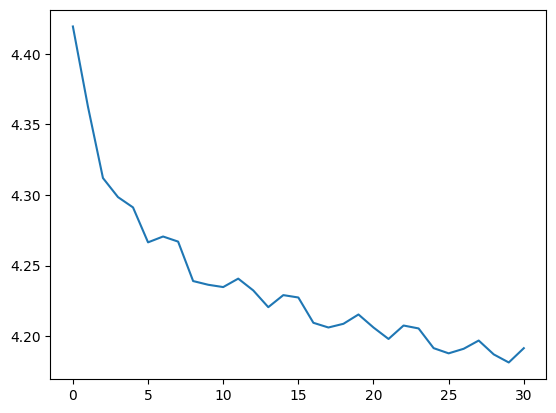

 88%|████████▊ | 7/8 [00:12<00:01,  1.87s/it]

Batch 7: Loss = 4.1886, Accuracy = 0.0411


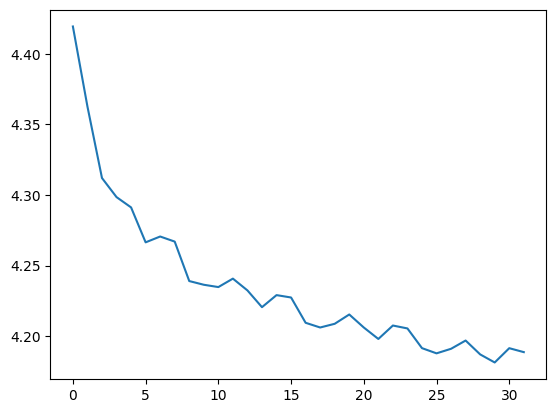

100%|██████████| 8/8 [00:13<00:00,  1.74s/it]


Epoch 3 completed.


  0%|          | 0/8 [00:00<?, ?it/s]

Batch 0: Loss = 4.1768, Accuracy = 0.0391


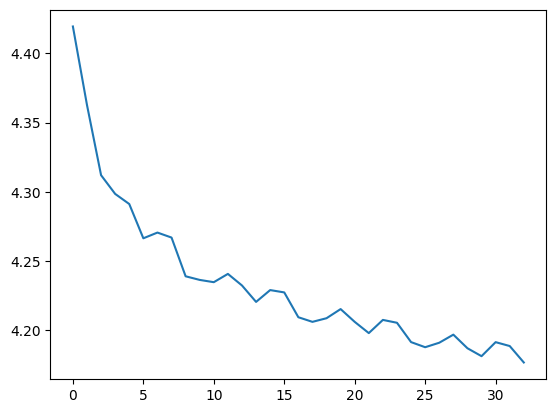

 12%|█▎        | 1/8 [00:01<00:12,  1.76s/it]

Batch 1: Loss = 4.1730, Accuracy = 0.0312


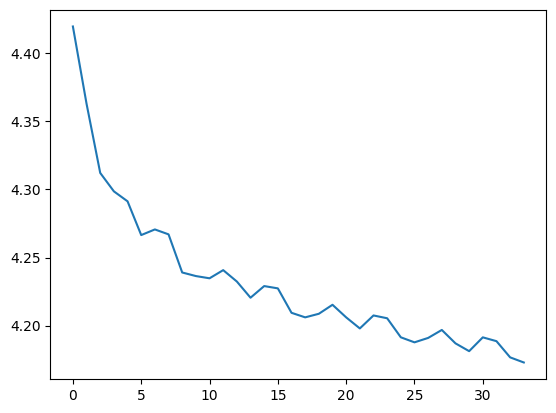

 25%|██▌       | 2/8 [00:03<00:10,  1.79s/it]

Batch 2: Loss = 4.1762, Accuracy = 0.0293


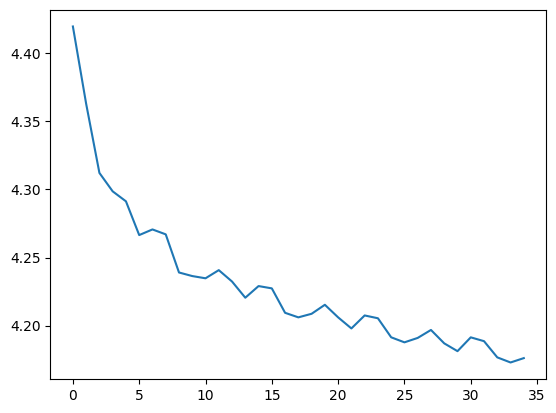

 38%|███▊      | 3/8 [00:05<00:08,  1.75s/it]

Batch 3: Loss = 4.1815, Accuracy = 0.0283


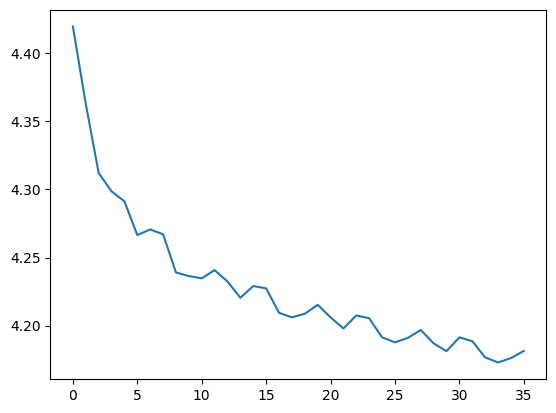

 50%|█████     | 4/8 [00:06<00:06,  1.73s/it]

Batch 4: Loss = 4.1711, Accuracy = 0.0283


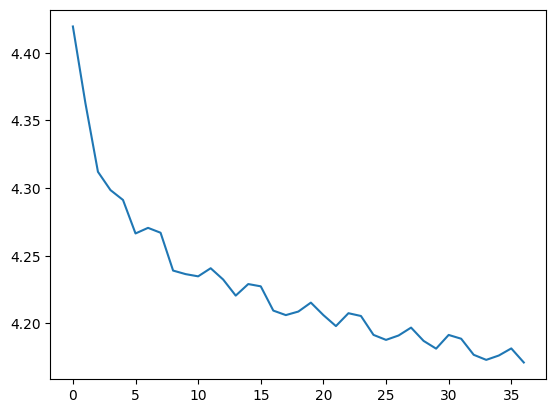

 62%|██████▎   | 5/8 [00:08<00:05,  1.73s/it]

Batch 5: Loss = 4.1671, Accuracy = 0.0449


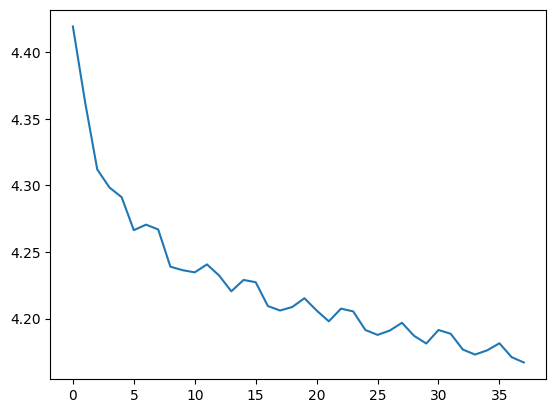

 75%|███████▌  | 6/8 [00:10<00:03,  1.73s/it]

Batch 6: Loss = 4.1778, Accuracy = 0.0303


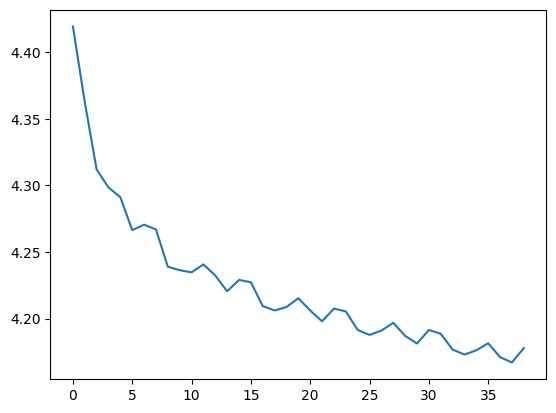

 88%|████████▊ | 7/8 [00:12<00:01,  1.73s/it]

Batch 7: Loss = 4.1740, Accuracy = 0.0488


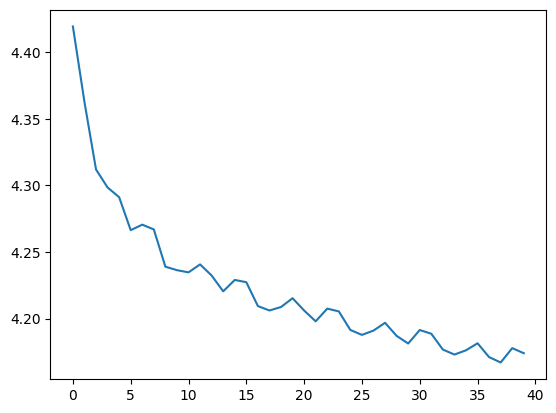

100%|██████████| 8/8 [00:13<00:00,  1.70s/it]


Epoch 4 completed.


  0%|          | 0/8 [00:00<?, ?it/s]

Batch 0: Loss = 4.1637, Accuracy = 0.0420


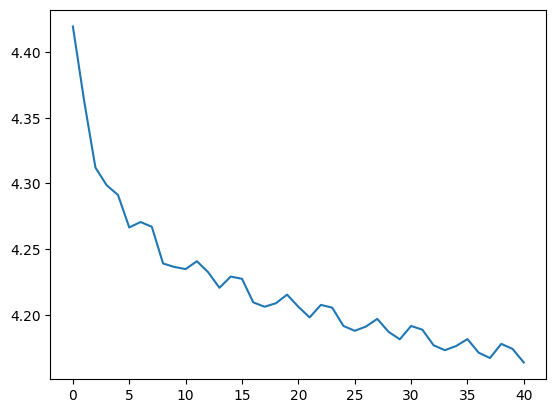

 12%|█▎        | 1/8 [00:01<00:12,  1.76s/it]

Batch 1: Loss = 4.1599, Accuracy = 0.0361


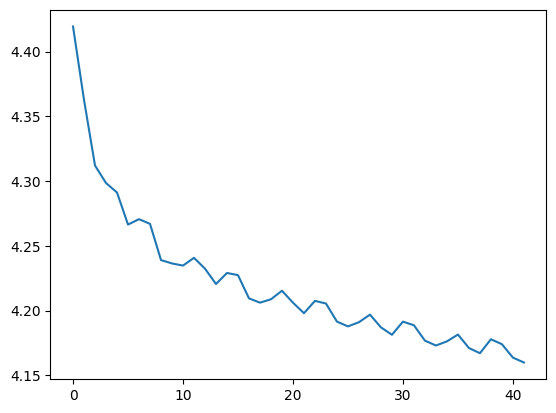

 25%|██▌       | 2/8 [00:03<00:10,  1.76s/it]

Batch 2: Loss = 4.1628, Accuracy = 0.0303


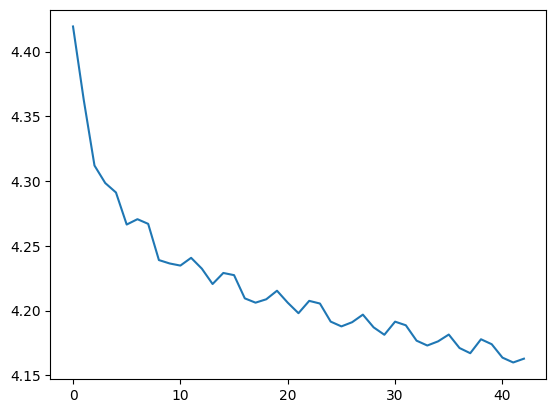

 38%|███▊      | 3/8 [00:05<00:08,  1.75s/it]

Batch 3: Loss = 4.1679, Accuracy = 0.0312


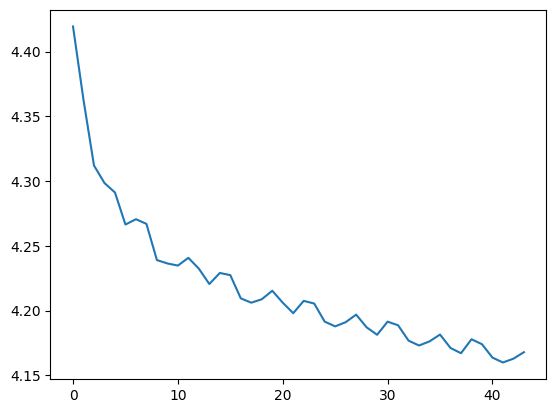

 50%|█████     | 4/8 [00:06<00:06,  1.74s/it]

Batch 4: Loss = 4.1569, Accuracy = 0.0371


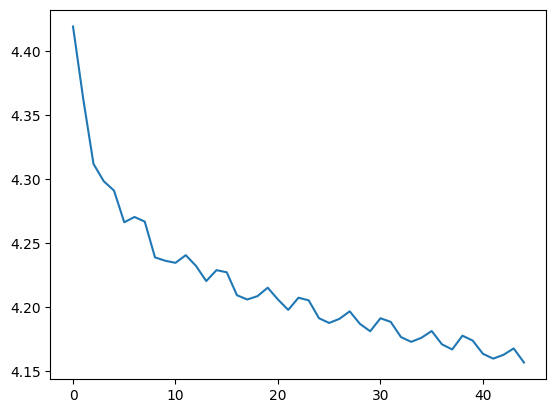

 62%|██████▎   | 5/8 [00:08<00:05,  1.72s/it]

Batch 5: Loss = 4.1542, Accuracy = 0.0479


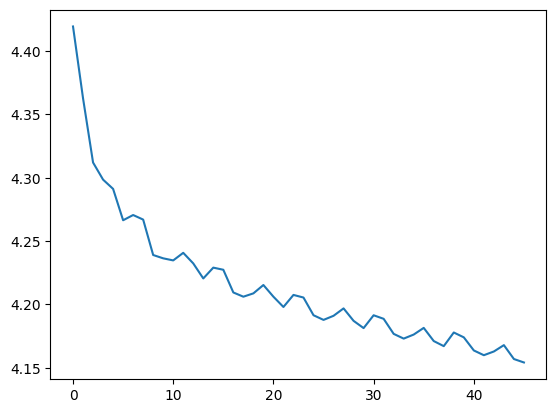

 75%|███████▌  | 6/8 [00:10<00:03,  1.69s/it]

Batch 6: Loss = 4.1657, Accuracy = 0.0352


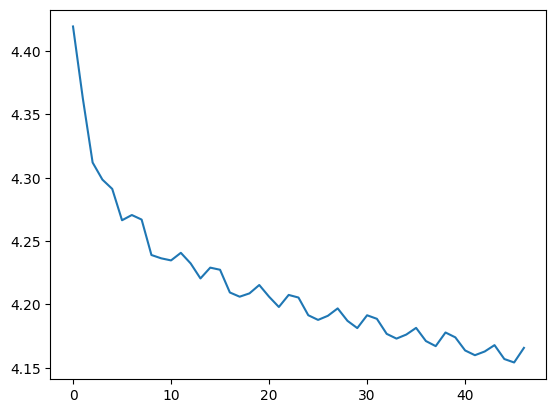

 88%|████████▊ | 7/8 [00:11<00:01,  1.68s/it]

Batch 7: Loss = 4.1607, Accuracy = 0.0527


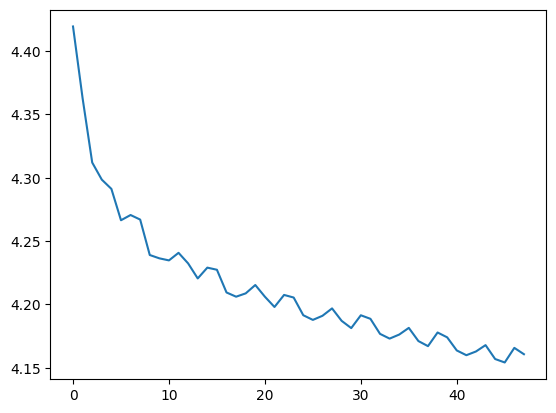

100%|██████████| 8/8 [00:13<00:00,  1.67s/it]


Epoch 5 completed.


  0%|          | 0/8 [00:00<?, ?it/s]

Batch 0: Loss = 4.1517, Accuracy = 0.0449


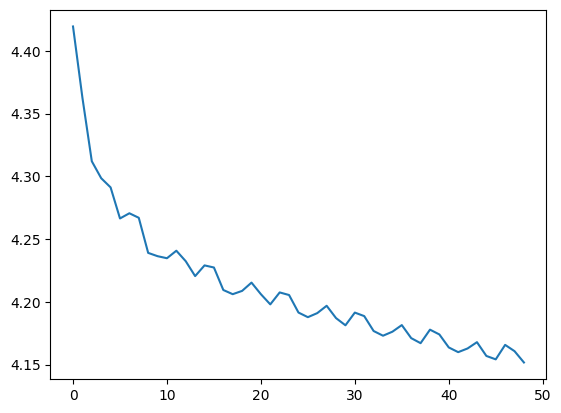

 12%|█▎        | 1/8 [00:02<00:14,  2.13s/it]

Batch 1: Loss = 4.1478, Accuracy = 0.0439


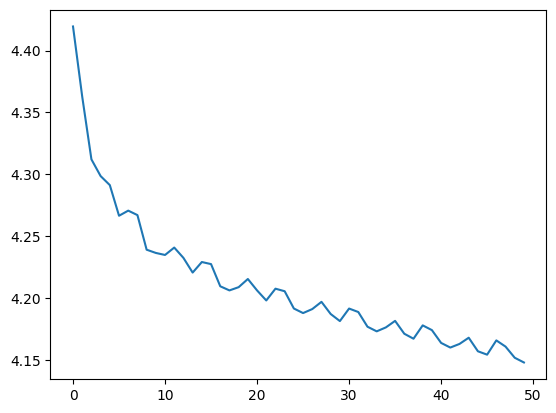

 25%|██▌       | 2/8 [00:03<00:11,  1.93s/it]

Batch 2: Loss = 4.1504, Accuracy = 0.0361


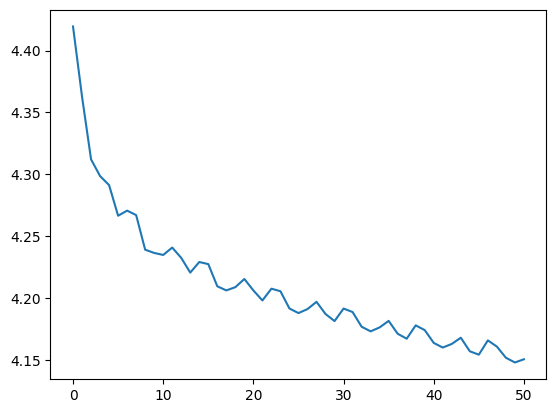

 38%|███▊      | 3/8 [00:05<00:09,  1.88s/it]

Batch 3: Loss = 4.1554, Accuracy = 0.0361


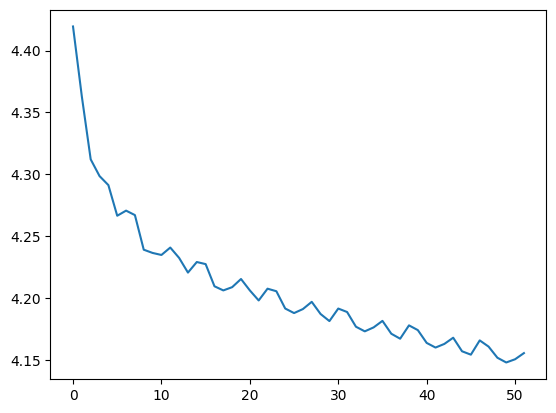

 50%|█████     | 4/8 [00:07<00:07,  1.79s/it]

Batch 4: Loss = 4.1439, Accuracy = 0.0381


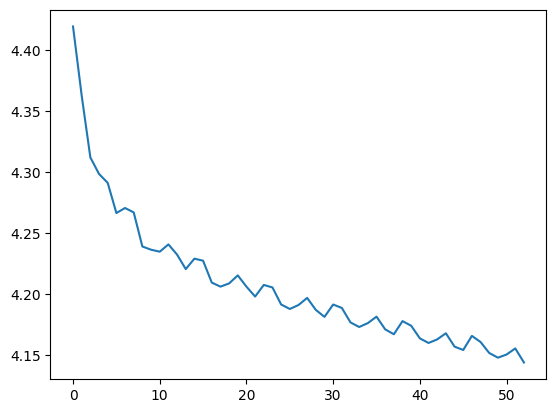

 62%|██████▎   | 5/8 [00:09<00:05,  1.73s/it]

Batch 5: Loss = 4.1422, Accuracy = 0.0479


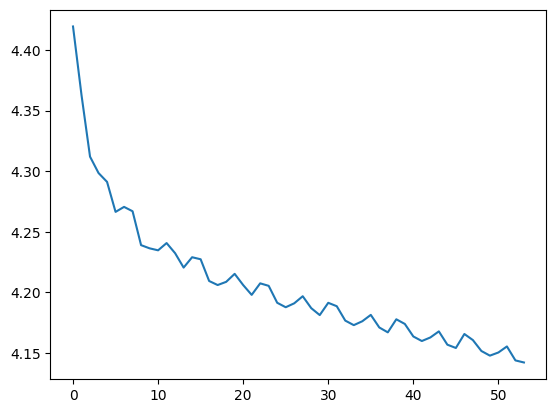

 75%|███████▌  | 6/8 [00:10<00:03,  1.73s/it]

Batch 6: Loss = 4.1546, Accuracy = 0.0342


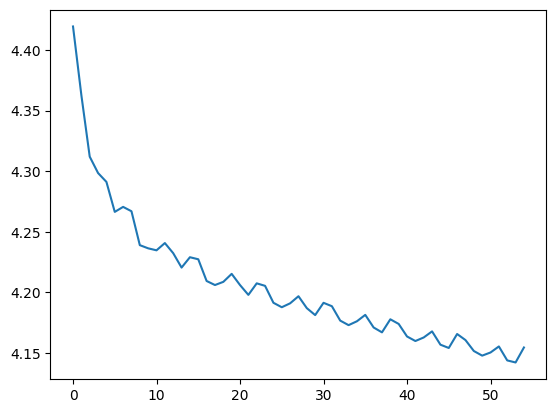

 88%|████████▊ | 7/8 [00:12<00:01,  1.76s/it]

Batch 7: Loss = 4.1484, Accuracy = 0.0566


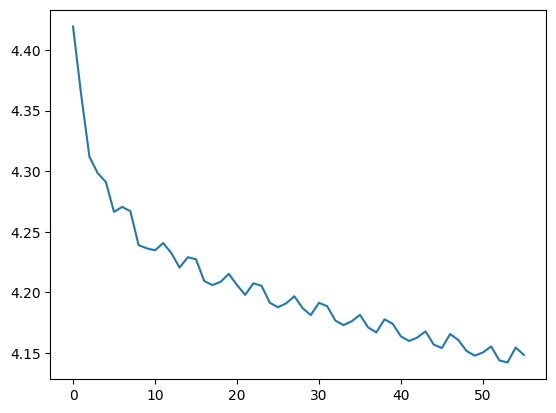

100%|██████████| 8/8 [00:14<00:00,  1.75s/it]


Epoch 6 completed.


  0%|          | 0/8 [00:00<?, ?it/s]

Batch 0: Loss = 4.1406, Accuracy = 0.0449


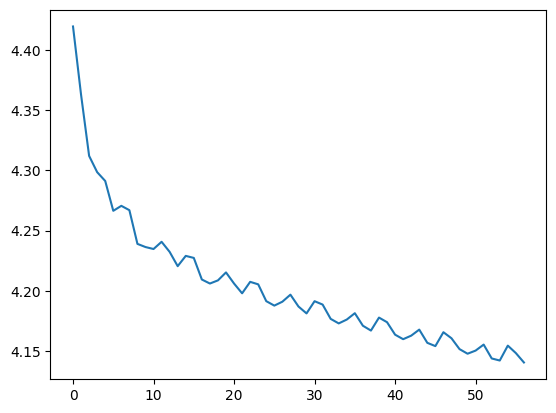

 12%|█▎        | 1/8 [00:01<00:12,  1.71s/it]

Batch 1: Loss = 4.1366, Accuracy = 0.0498


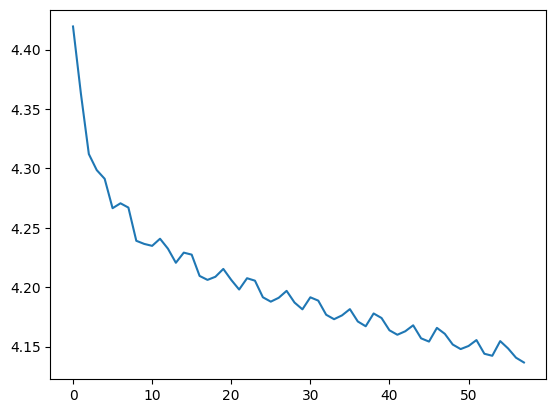

 25%|██▌       | 2/8 [00:03<00:10,  1.73s/it]

Batch 2: Loss = 4.1389, Accuracy = 0.0410


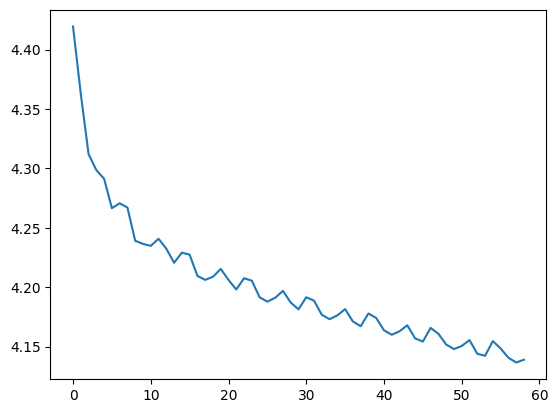

 38%|███▊      | 3/8 [00:05<00:08,  1.74s/it]

Batch 3: Loss = 4.1439, Accuracy = 0.0391


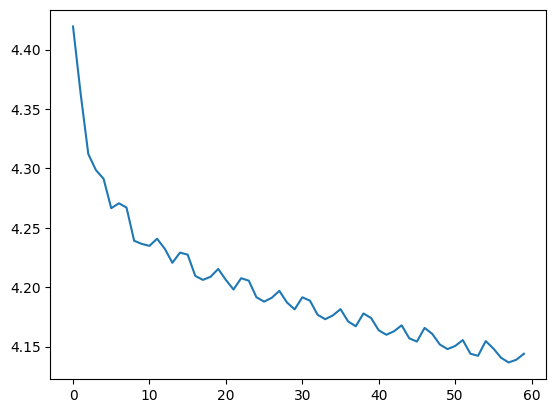

 50%|█████     | 4/8 [00:06<00:06,  1.74s/it]

Batch 4: Loss = 4.1319, Accuracy = 0.0391


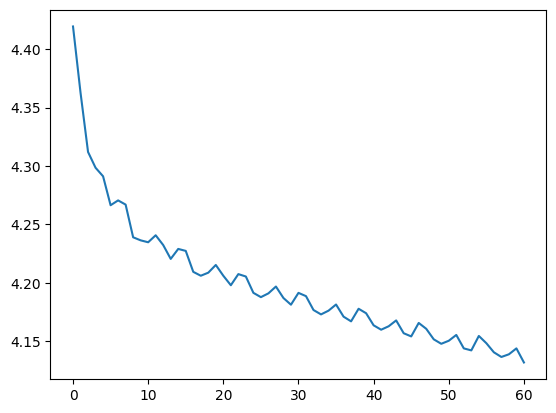

 62%|██████▎   | 5/8 [00:08<00:05,  1.74s/it]

Batch 5: Loss = 4.1310, Accuracy = 0.0547


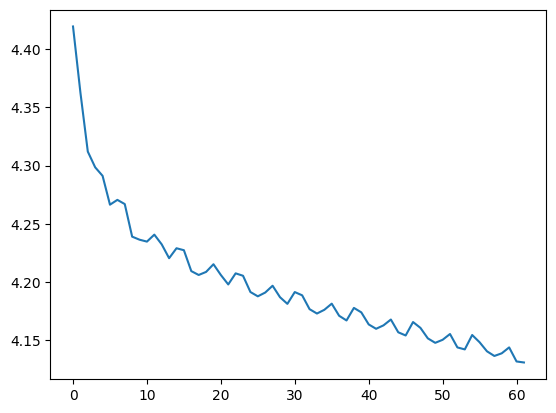

 75%|███████▌  | 6/8 [00:10<00:03,  1.74s/it]

Batch 6: Loss = 4.1442, Accuracy = 0.0352


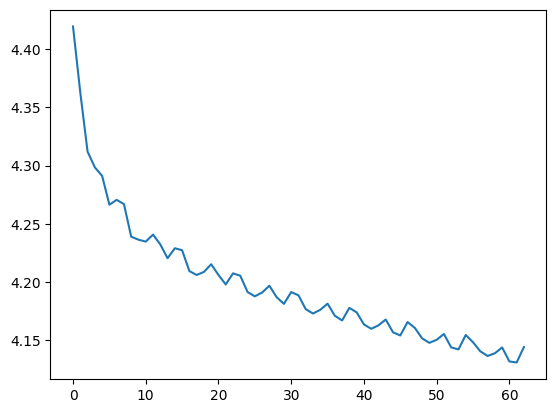

 88%|████████▊ | 7/8 [00:12<00:01,  1.74s/it]

Batch 7: Loss = 4.1369, Accuracy = 0.0540


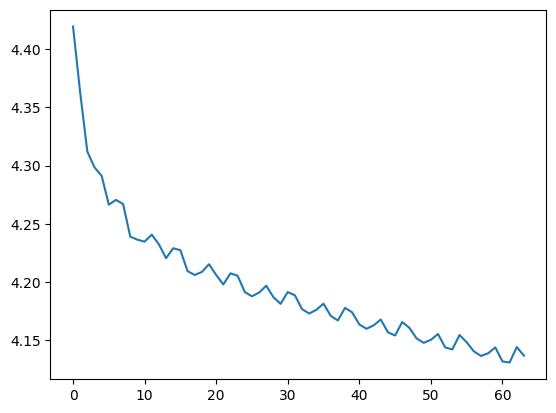

100%|██████████| 8/8 [00:13<00:00,  1.70s/it]


Epoch 7 completed.


  0%|          | 0/8 [00:00<?, ?it/s]

Batch 0: Loss = 4.1302, Accuracy = 0.0469


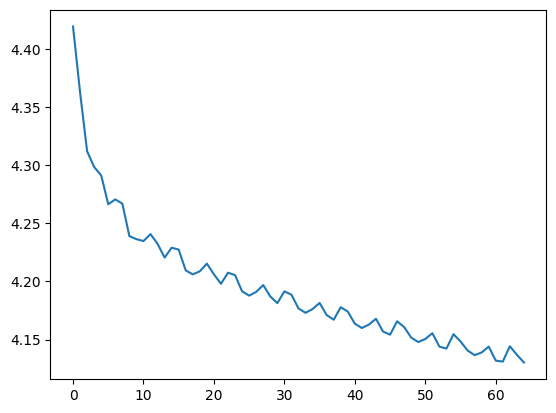

 12%|█▎        | 1/8 [00:01<00:12,  1.73s/it]

Batch 1: Loss = 4.1259, Accuracy = 0.0527


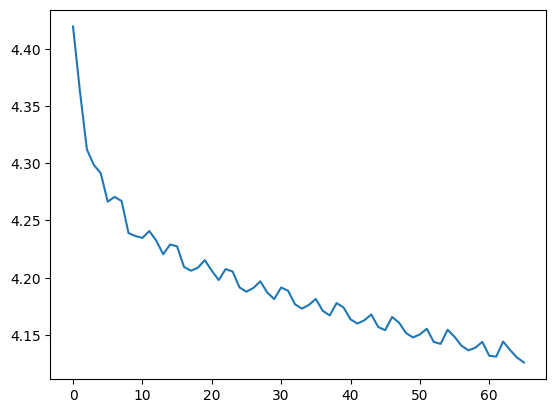

 25%|██▌       | 2/8 [00:03<00:10,  1.73s/it]

Batch 2: Loss = 4.1280, Accuracy = 0.0459


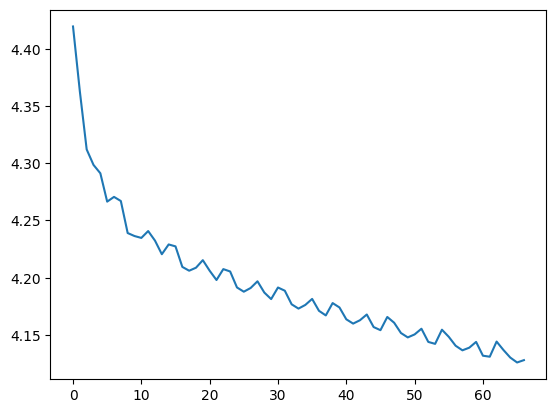

 38%|███▊      | 3/8 [00:05<00:08,  1.74s/it]

Batch 3: Loss = 4.1332, Accuracy = 0.0420


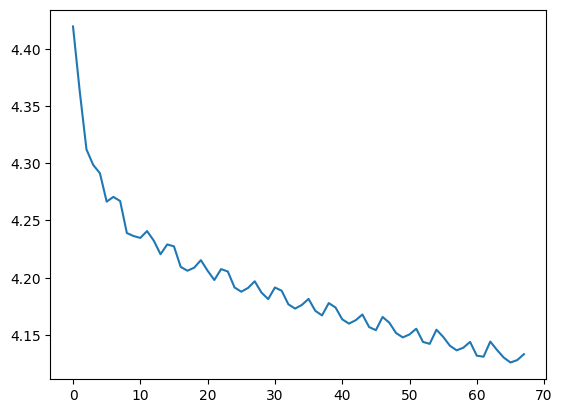

 50%|█████     | 4/8 [00:07<00:07,  1.99s/it]

Batch 4: Loss = 4.1206, Accuracy = 0.0459


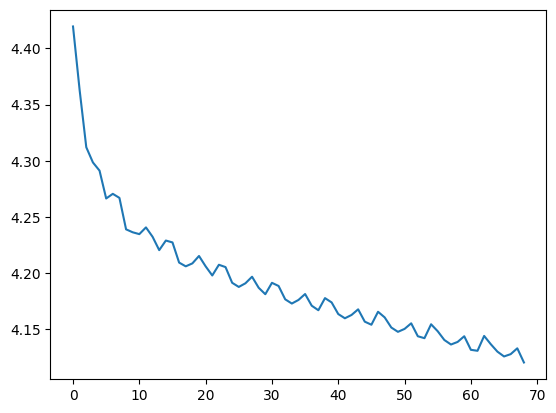

 62%|██████▎   | 5/8 [00:09<00:05,  1.91s/it]

Batch 5: Loss = 4.1204, Accuracy = 0.0566


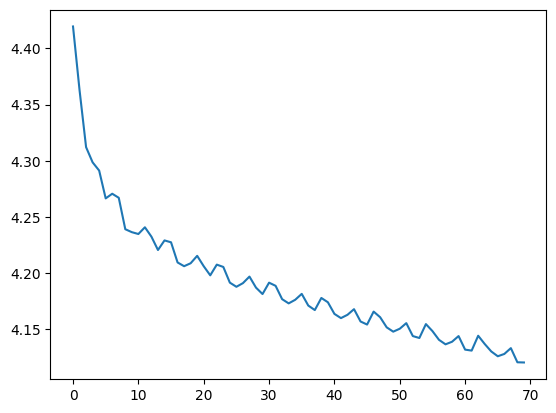

 75%|███████▌  | 6/8 [00:11<00:03,  1.86s/it]

Batch 6: Loss = 4.1344, Accuracy = 0.0342


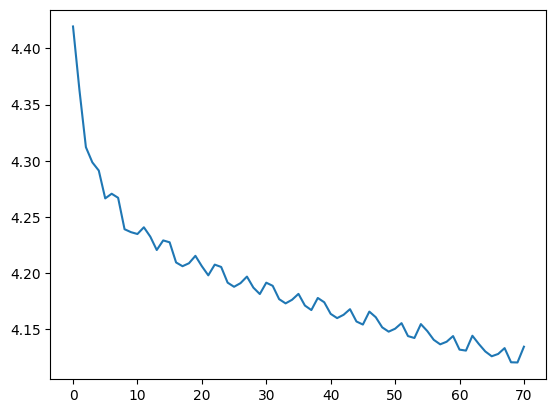

 88%|████████▊ | 7/8 [00:12<00:01,  1.82s/it]

Batch 7: Loss = 4.1261, Accuracy = 0.0591


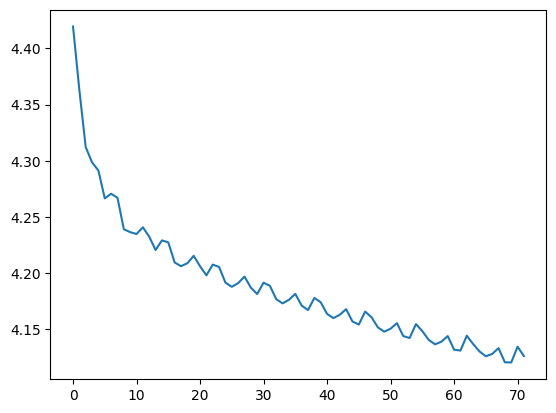

100%|██████████| 8/8 [00:14<00:00,  1.78s/it]


Epoch 8 completed.


  0%|          | 0/8 [00:00<?, ?it/s]

Batch 0: Loss = 4.1206, Accuracy = 0.0459


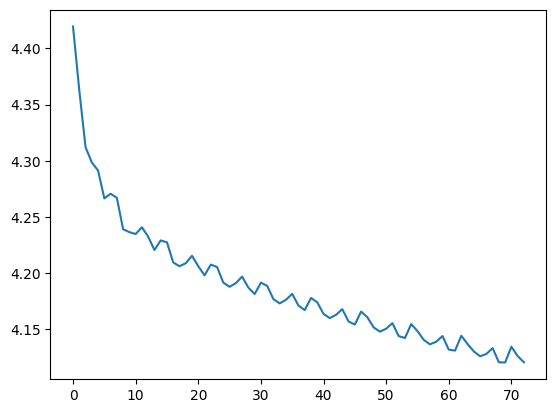

 12%|█▎        | 1/8 [00:01<00:12,  1.75s/it]

Batch 1: Loss = 4.1159, Accuracy = 0.0527


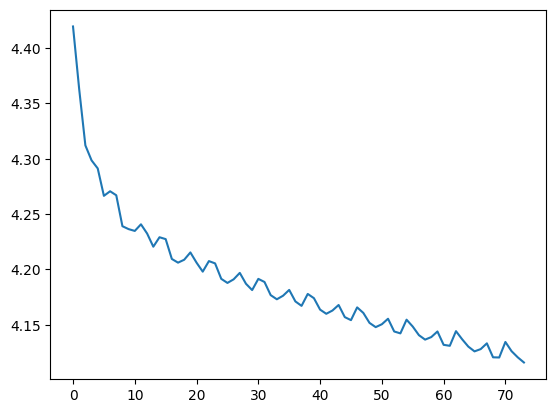

 25%|██▌       | 2/8 [00:03<00:10,  1.75s/it]

Batch 2: Loss = 4.1178, Accuracy = 0.0508


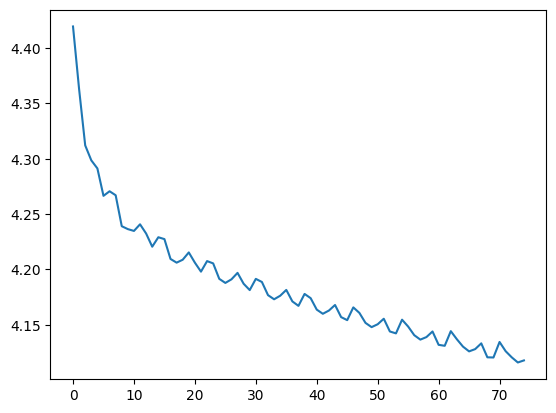

 38%|███▊      | 3/8 [00:05<00:08,  1.76s/it]

Batch 3: Loss = 4.1231, Accuracy = 0.0420


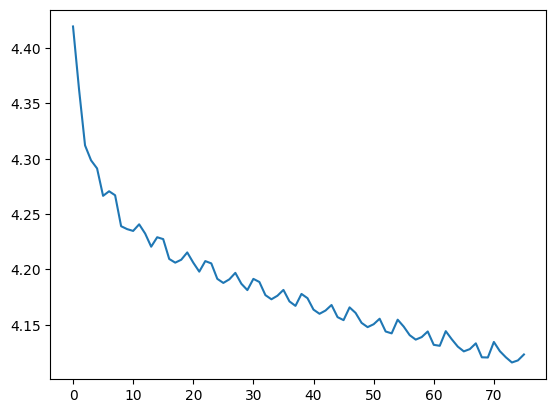

 50%|█████     | 4/8 [00:07<00:07,  1.75s/it]

Batch 4: Loss = 4.1100, Accuracy = 0.0469


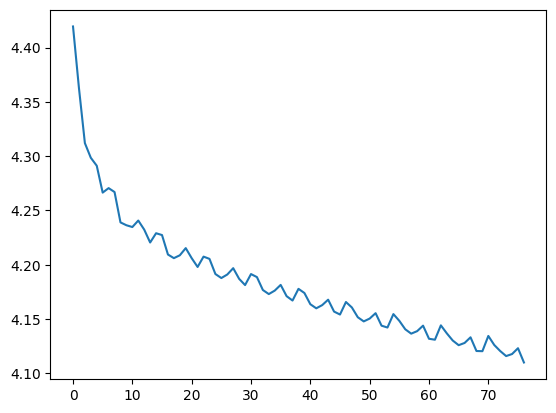

 62%|██████▎   | 5/8 [00:08<00:05,  1.75s/it]

Batch 5: Loss = 4.1104, Accuracy = 0.0576


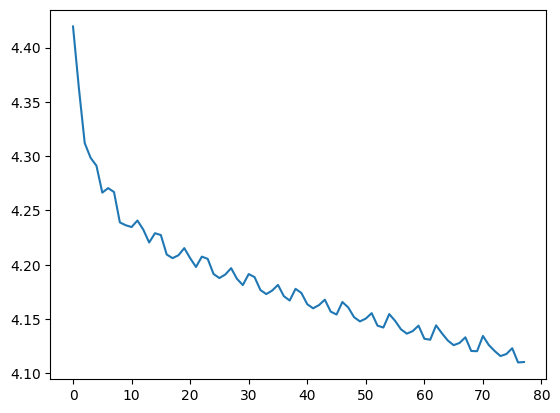

 75%|███████▌  | 6/8 [00:10<00:03,  1.84s/it]

Batch 6: Loss = 4.1252, Accuracy = 0.0342


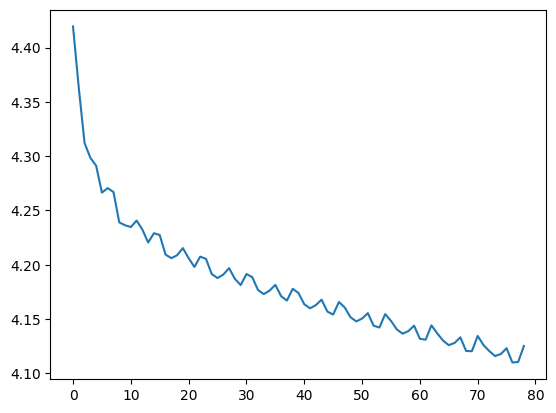

 88%|████████▊ | 7/8 [00:12<00:01,  1.82s/it]

Batch 7: Loss = 4.1160, Accuracy = 0.0643


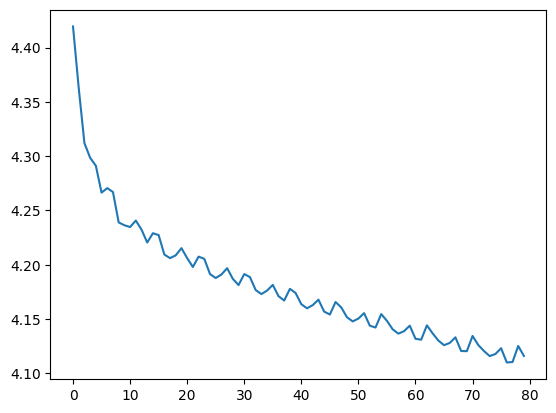

100%|██████████| 8/8 [00:13<00:00,  1.75s/it]

Epoch 9 completed.


In [23]:
W1, b1, W2, b2 = train(X_train, Y_train, 0.01, 1024, 10)